In [295]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [349]:
import os
import zipfile
import urllib.request
import pandas as pd
import numpy as np
from keras.layers import *
from keras.callbacks import *
from keras.models import Model
from keras.utils import to_categorical

In [186]:
from numpy import mean
from numpy import std
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from matplotlib import pyplot

In [267]:
# Useful constants
url_dataset = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'

file_name = 'UCI HAR Dataset.zip'

data_dir = 'UCI HAR Dataset'

classes = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

nb_classes = len(classes)

validation_ratio = 0.3

# Overview:
1. Load Data
2. LSTM
3. CNN
4. Comparison (runtime, accuracy, etc.)

## 1. Load Data

In [36]:
#Download and Extract zip
if (not os.path.exists(file_name)):
    # Download
    print('Download in progress...')
    urllib.request.urlretrieve(url_dataset, file_name)
    print('Finished downloading')

    # Extract
    with zipfile.ZipFile(file_name,"r") as zip_ref:
        zip_ref.extractall()
    print('Finished extracting zip')
else:
    print('Zip file exists')

Download in progress...
Finished downloading
Finished extracting zip


In [439]:
def grab_filenames(partition='train'):
    files = os.listdir(os.path.join(data_dir,partition,'Inertial Signals'))
    #only keep body_gyro and total_acc files
    keep_files = ['body_gyro', 'total_acc']
    files = [file for file in files if any(keep_file in file for keep_file in keep_files)]
    return files

In [339]:
def load_X_files(partition, files):
    data = []
    for file in files:
        txt = pd.read_csv(os.path.join(data_dir,partition,'Inertial Signals',file),header=None,sep='\s+',dtype=np.float64)
        data.append(txt.values)
    data = np.dstack(data) 
    return data

In [340]:
def load_Y_files(partition):
    data = pd.read_csv(os.path.join(data_dir,partition,'y_'+partition+'.txt'),header=None)
    return data.values

In [341]:
def load_files(partition):
    files = grab_filenames(partition)
    X = load_X_files(partition, files)
    Y = load_Y_files(partition)
    print('Reading X_{} with shape: {}'.format(partition,X.shape))
    print('Reading Y_{} with shape: {}'.format(partition,Y.shape))
    return X,Y

In [573]:
X_train, Y_train = load_files('train')
X_test, Y_test_cat = load_files('test')

Reading X_train with shape: (7352, 128, 6)
Reading Y_train with shape: (7352, 1)
Reading X_test with shape: (2947, 128, 6)
Reading Y_test with shape: (2947, 1)


In [574]:
#recode: class numbers must be 0-5 (previously 1-6)
Y_train = to_categorical(Y_train-1) 
Y_test = to_categorical(Y_test_cat-1)

In [575]:
Y_test_cat = [item[0] for item in Y_test_cat]

## 2. LSTM

In [448]:
def custom_lstm(lstm_units):
    input_smartphone = Input(shape=(X_train.shape[1],X_train.shape[2]), name='input_smartphone')
        
    x = LSTM(lstm_units, return_sequences=True)(input_smartphone)
    x = LSTM(lstm_units, return_sequences=False)(x)
        
    output = Dense(nb_classes, activation='softmax', name='output')(x)

    model = Model(inputs=input_smartphone,outputs=output) 
    return model

In [449]:
def train_model(model, X, Y, batch_size=64, epochs=100, callbacks=callbacks):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    results = model.fit(X,Y,
                        validation_split = validation_ratio,
                        batch_size = batch_size,
                        epochs = epochs,
                        verbose = 1,
                        callbacks = callbacks)
    results = results.history
    return results

In [450]:
#callbacks
reduce_lr = ReduceLROnPlateau(patience=5, min_lr=0.00001)
stop_early = EarlyStopping(patience=10)
model_ckpt = ModelCheckpoint(filepath='weights_lstm.hdf5', save_best_only=True)
callbacks = [reduce_lr, stop_early, model_ckpt]

In [451]:
model = custom_lstm(lstm_units=100)
results = train_model(model,X_train,Y_train,batch_size=32,callbacks=callbacks)

Train on 5146 samples, validate on 2206 samples
Epoch 1/100
5146/5146 [==============================] - 321s 62ms/step - loss: 1.0877 - acc: 0.5346 - val_loss: 0.9787 - val_acc: 0.5739
Epoch 2/100
5146/5146 [==============================] - 481s 94ms/step - loss: 0.7278 - acc: 0.6867 - val_loss: 0.7257 - val_acc: 0.7221
Epoch 3/100
5146/5146 [==============================] - 321s 62ms/step - loss: 0.5845 - acc: 0.7620 - val_loss: 0.7136 - val_acc: 0.7584
Epoch 4/100
5146/5146 [==============================] - 342s 66ms/step - loss: 0.5074 - acc: 0.8004 - val_loss: 0.6556 - val_acc: 0.8015
Epoch 5/100
5146/5146 [==============================] - 258s 50ms/step - loss: 0.4287 - acc: 0.8372 - val_loss: 0.5223 - val_acc: 0.8563
Epoch 6/100
5146/5146 [==============================] - 85s 17ms/step - loss: 0.3274 - acc: 0.8760 - val_loss: 0.4385 - val_acc: 0.8849
Epoch 7/100
5146/5146 [==============================] - 83s 16ms/step - loss: 0.3129 - acc: 0.8844 - val_loss: 0.3970 - val_

In [417]:
#load best model
model = custom_lstm(lstm_units=100)
model.load_weights('weights_lstm.hdf5')

In [418]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_smartphone (InputLayer (None, 128, 6)            0         
_________________________________________________________________
lstm_74 (LSTM)               (None, 128, 100)          42800     
_________________________________________________________________
lstm_75 (LSTM)               (None, 100)               80400     
_________________________________________________________________
output (Dense)               (None, 6)                 606       
Total params: 123,806
Trainable params: 123,806
Non-trainable params: 0
_________________________________________________________________


## 3. 1D-CNN

In [564]:
def custom_1d_cnn(conv_units):
    input_smartphone = Input(shape=(X_train.shape[1], X_train.shape[2] ), name='input_smartphone')
        
    x = Conv1D(conv_units, kernel_size=3, activation='relu')(input_smartphone)
    x = Conv1D(conv_units, kernel_size=3, activation='relu')(x)
    x = MaxPool1D(pool_size=2)(x)
    x = Conv1D(conv_units, kernel_size=3, activation='relu')(x)
    x = Conv1D(conv_units, kernel_size=3, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    
    output = Dense(nb_classes, activation='softmax', name='output')(x)

    model = Model(inputs=input_smartphone,outputs=output) 
    return model

In [565]:
#callbacks
reduce_lr = ReduceLROnPlateau(patience=5, min_lr=0.00001)
stop_early = EarlyStopping(patience=10)
model_ckpt = ModelCheckpoint(filepath='weights_1dcnn.hdf5', save_best_only=True)
callbacks = [reduce_lr, stop_early, model_ckpt]

In [567]:
model = custom_1d_cnn(conv_units=128)

In [576]:
model = custom_1d_cnn(conv_units=128)
results = train_model(model,X_train,Y_train,batch_size=32,callbacks=callbacks)

Train on 5146 samples, validate on 2206 samples
Epoch 1/100
5146/5146 [==============================] - 18s 4ms/step - loss: 0.6862 - acc: 0.7064 - val_loss: 0.5634 - val_acc: 0.8250
Epoch 2/100
5146/5146 [==============================] - 14s 3ms/step - loss: 0.3762 - acc: 0.8519 - val_loss: 0.5094 - val_acc: 0.8835
Epoch 3/100
5146/5146 [==============================] - 15s 3ms/step - loss: 0.2643 - acc: 0.8951 - val_loss: 0.5148 - val_acc: 0.8976
Epoch 4/100
5146/5146 [==============================] - 18s 3ms/step - loss: 0.1924 - acc: 0.9225 - val_loss: 0.5285 - val_acc: 0.9175
Epoch 5/100
5146/5146 [==============================] - 18s 3ms/step - loss: 0.1767 - acc: 0.9298 - val_loss: 0.5189 - val_acc: 0.9048
Epoch 6/100
5146/5146 [==============================] - 18s 3ms/step - loss: 0.1462 - acc: 0.9376 - val_loss: 0.4959 - val_acc: 0.9266
Epoch 7/100
5146/5146 [==============================] - 18s 3ms/step - loss: 0.1210 - acc: 0.9456 - val_loss: 0.5642 - val_acc: 0.9102


In [553]:
#load best model
model = custom_1d_cnn(conv_units=128)
model.load_weights('weights_1dcnn.hdf5')

In [554]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_smartphone (InputLayer (None, 128, 6)            0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 126, 128)          2432      
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 63, 128)           0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 61, 128)           49280     
_________________________________________________________________
global_average_pooling1d_20  (None, 128)               0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 6)                 774       
Total para

## 4. Comparison: LSTM vs. 1D-CNN

In [494]:
from sklearn.metrics import confusion_matrix
import itertools

In [528]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [577]:
#load best models
model_lstm = custom_lstm(lstm_units=100)
model_lstm.load_weights('weights_lstm.hdf5')

model_cnn = custom_1d_cnn(conv_units=128)
model_cnn.load_weights('weights_1dcnn.hdf5')

### Comparison: Accuracy

In [578]:
preds_lstm = model_lstm.predict(X_test)
preds_cnn = model_cnn.predict(X_test)

#get back classes from labels (convert from 0 start index back to 1)
preds_class_lstm = [np.argmax(item)+1 for item in preds_lstm]
preds_class_cnn = [np.argmax(item)+1 for item in preds_cnn]

Confusion matrix, without normalization
[[404   8  79   5   0   0]
 [ 13 423  35   0   0   0]
 [  1   2 408   8   1   0]
 [  0   1   0 418  51  21]
 [  1   3   4 133 391   0]
 [  0  40   0   0   0 497]]


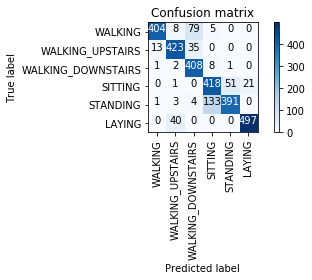

In [579]:
#LSTM
conf_lstm = confusion_matrix(y_true=Y_test_cat, y_pred=preds_class_lstm)
plot_confusion_matrix(conf_lstm, classes=classes)

Confusion matrix, without normalization
[[440   6  50   0   0   0]
 [  0 430  41   0   0   0]
 [ 10  11 393   6   0   0]
 [  0  26   0 421  44   0]
 [  2  75   0 112 343   0]
 [  0  43   0   0   0 494]]


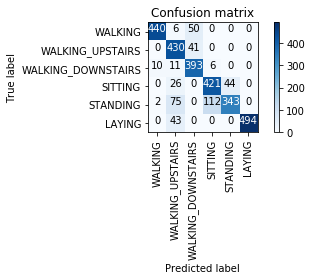

In [580]:
#CNN
conf_cnn = confusion_matrix(y_true=Y_test_cat, y_pred=preds_class_cnn)
plot_confusion_matrix(conf_cnn, classes=classes)

In [581]:
#overall test accuracy 
np.sum(np.diag(conf_lstm)) / np.sum(conf_lstm)

0.8622327790973872

In [582]:
np.sum(np.diag(conf_cnn)) / np.sum(conf_cnn)

0.8554462164913471

### Comparison: Runtime (10 reps)

In [540]:
%%timeit -r 10
preds = model_lstm.predict(X_train, batch_size=32)

20.4 s ± 1.01 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [583]:
%%timeit -r 10
preds = model_cnn.predict(X_train, batch_size=32)

5.22 s ± 778 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
